# Bibliotecas

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder,KBinsDiscretizer,StandardScaler, OrdinalEncoder,LabelBinarizer, LabelEncoder
from sklearn.linear_model import LogisticRegression,LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,ExtraTreesClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, plot_confusion_matrix, plot_roc_curve,classification_report,r2_score,confusion_matrix,make_scorer,precision_score,recall_score,roc_auc_score
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,StratifiedKFold,train_test_split
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import VarianceThreshold
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import numpy as np
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Funciones

In [37]:
def roc(modelo,X_test,y_test):
    probs = modelo.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title(modelo)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Tasa de verdaderos positivos')
    plt.xlabel('Tasa de falsos positivos')
    return plt.show()
def importancia_columnas(model, fea_names):
    fea_imp = []
    tops = []
    fea = model.feature_importances_
    idx = np.argsort(fea)
    fea_imp.append(fea)
    tops.append(fea_names[idx][:3])
    # print fea_names[idx][:3]
    plt.figure()
    plt.title("Feature importances")
    plt.barh(range(len(fea)), fea[idx], align="center")
    plt.yticks(range(len(fea)), fea_names[idx])
    plt.ylim([-1, len(fea)])
    plt.show()
    return fea_imp, tops

# Dataset

In [2]:
df=pd.read_csv("asistencia_limpio3.csv")

In [4]:
df.head()

,fecha_cita,horario_inicio,edad,departamento,asistencia,edad2,km,genero,dia_semana,semana,año,numero de visita,numero_total_visitas,nacionalidad2,inasistencias_previas,porcentaje_inasistencia_departamentos
0,2018-09-03,9,1954-01-09,integrada,SI,68,53,femenino,1,36,2018,1,45,ESP,0,0.184216
1,2018-09-03,9,1988-02-15,integrada,SI,34,10,femenino,1,36,2018,1,9,ESP,0,0.184216
2,2018-09-03,9,1948-01-14,integrada,SI,74,9,femenino,1,36,2018,1,1,ESP,0,0.184216
3,2018-09-03,9,1998-04-20,integrada,SI,23,14,femenino,1,36,2018,1,39,ESP,0,0.184216
4,2018-09-03,11,1959-08-24,integrada,SI,62,3,femenino,1,36,2018,1,4,ESP,0,0.184216


datos anonimizados de visitas de pacientes durante los 4 ultimos años con el target: Asistencia

# EDA

In [5]:
#No hay nulos, df ya limpio
df.isna().sum()

fecha_cita                               0
horario_inicio                           0
edad                                     0
departamento                             0
asistencia                               0
edad2                                    0
km                                       0
genero                                   0
dia_semana                               0
semana                                   0
año                                      0
numero de visita                         0
numero_total_visitas                     0
nacionalidad2                            0
inasistencias_previas                    0
porcentaje_inasistencia_departamentos    0
dtype: int64

<AxesSubplot:>

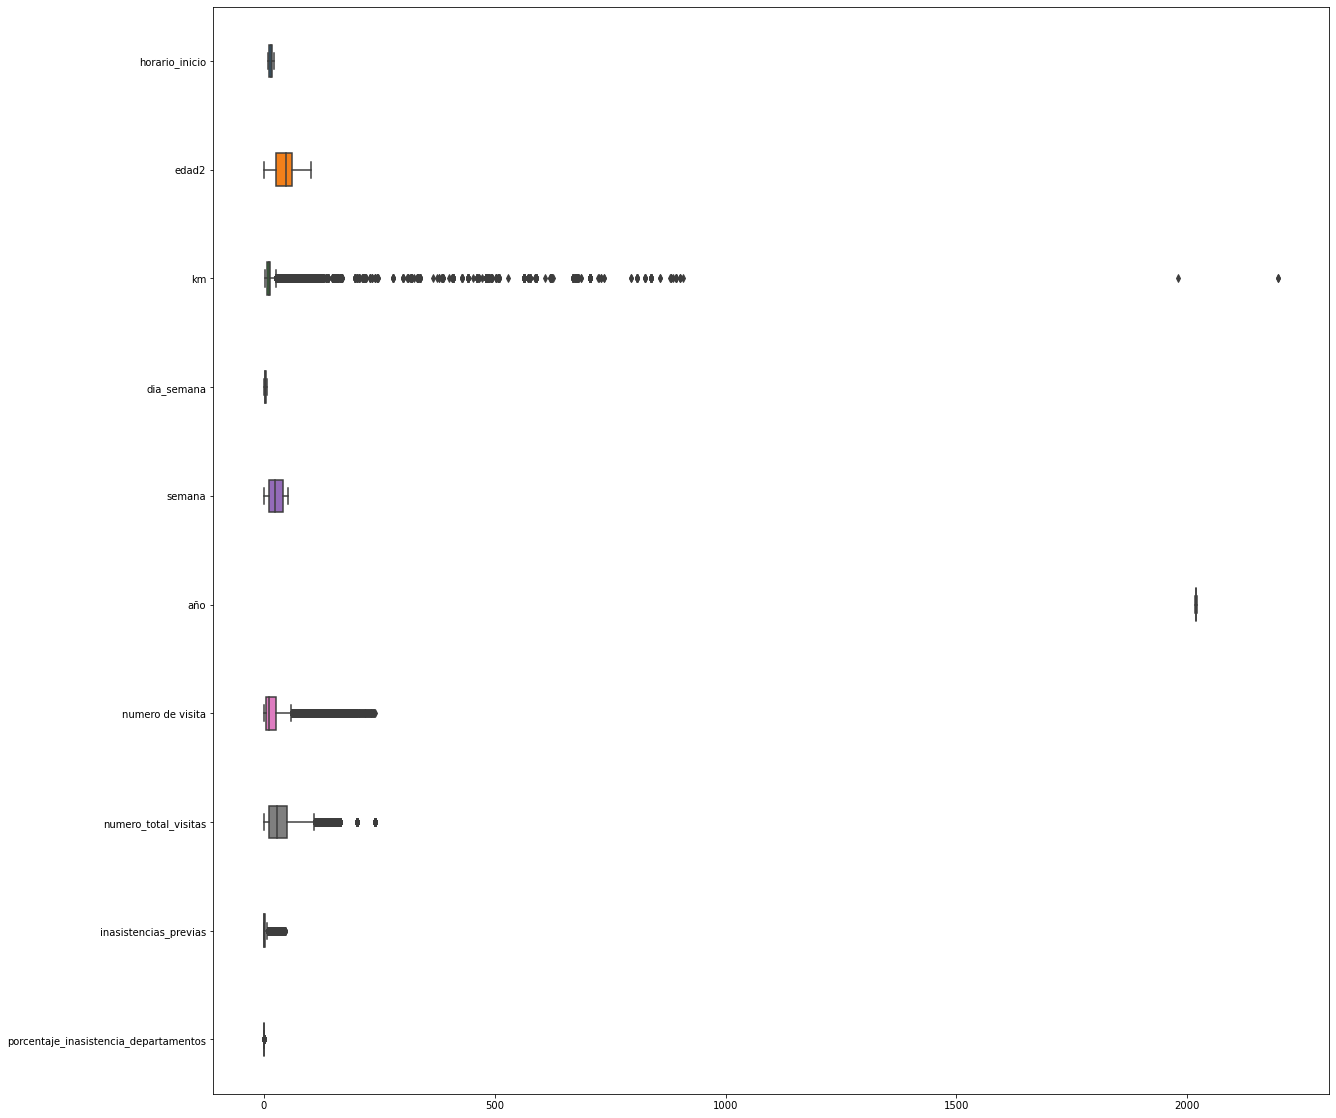

In [6]:
#muchos outliers en km
plt.figure(figsize=(20,20))
sns.boxplot(data=df, width=0.3, saturation=0.9, orient="h")

<AxesSubplot:xlabel='asistencia', ylabel='count'>

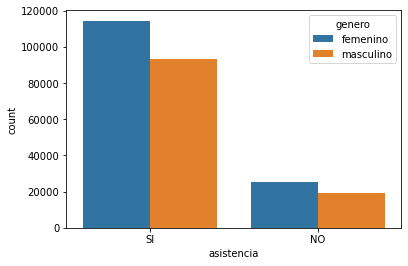

In [8]:
#mas mujeres que hombres y sin relacion con la no asistencia
sns.countplot(x="asistencia",hue="genero" , data=df)

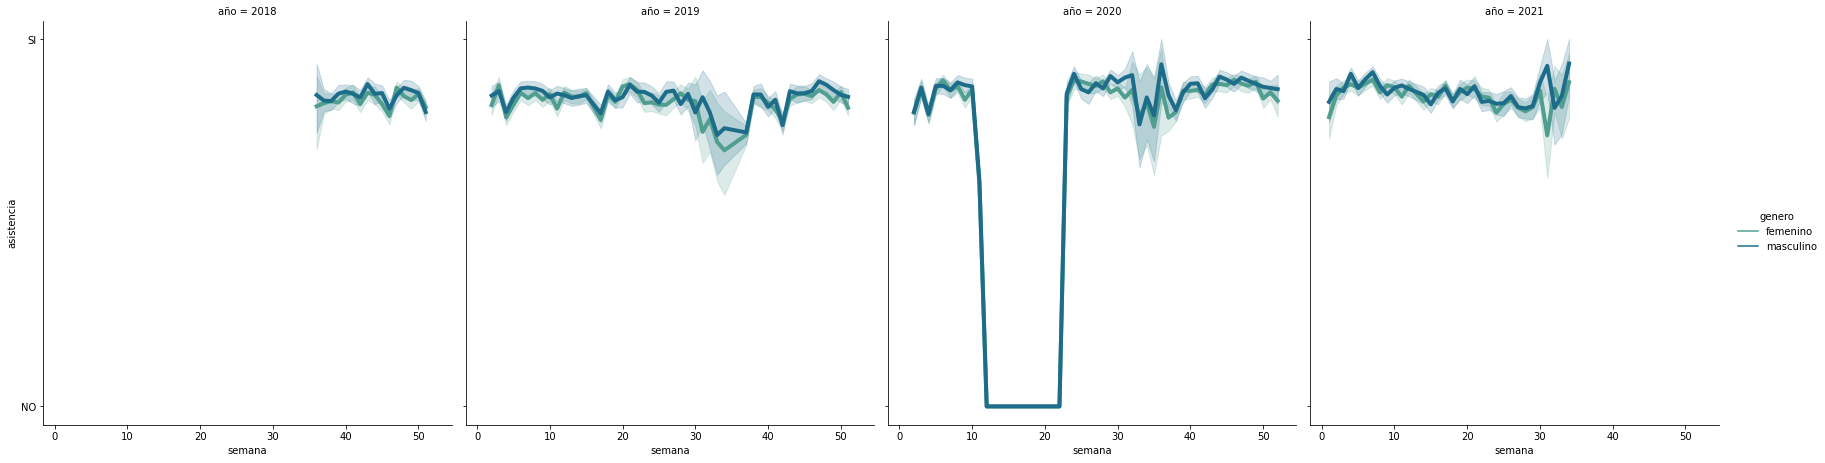

In [12]:
#distribucion de la asistencia semanal en estos 4 ultimos años
rp=sns.relplot(
    data=df,
    x="semana", y="asistencia", col="año", hue="genero",
    kind="line", palette="crest", linewidth=4, zorder=10,
    col_wrap=4, height=3, aspect=2, legend="auto",sizes=(10, 100)
)

rp.fig.subplots_adjust(top=2) 

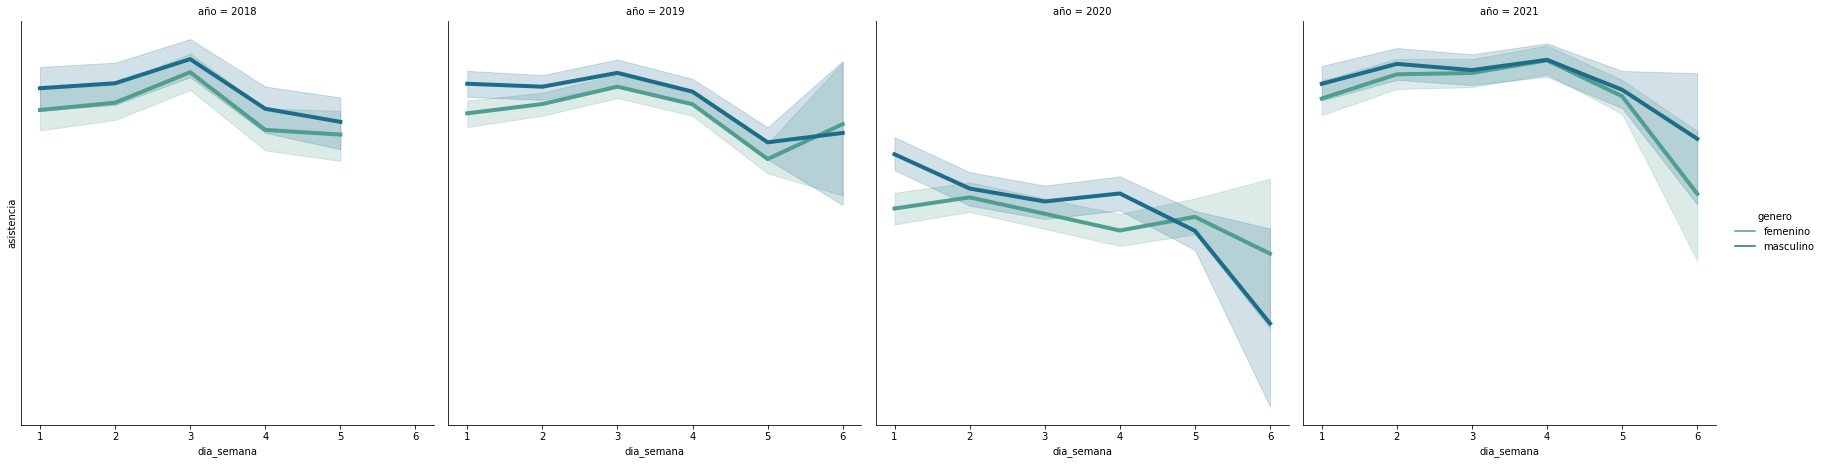

In [10]:
#asistencia por dias por semana segun el año y el genero
rp=sns.relplot(
    data=df,
    x="dia_semana", y="asistencia", col="año", hue="genero",
    kind="line", palette="crest", linewidth=4, zorder=10,
    col_wrap=4, height=3, aspect=2, legend="auto",sizes=(10, 100)
)

rp.fig.subplots_adjust(top=2) 

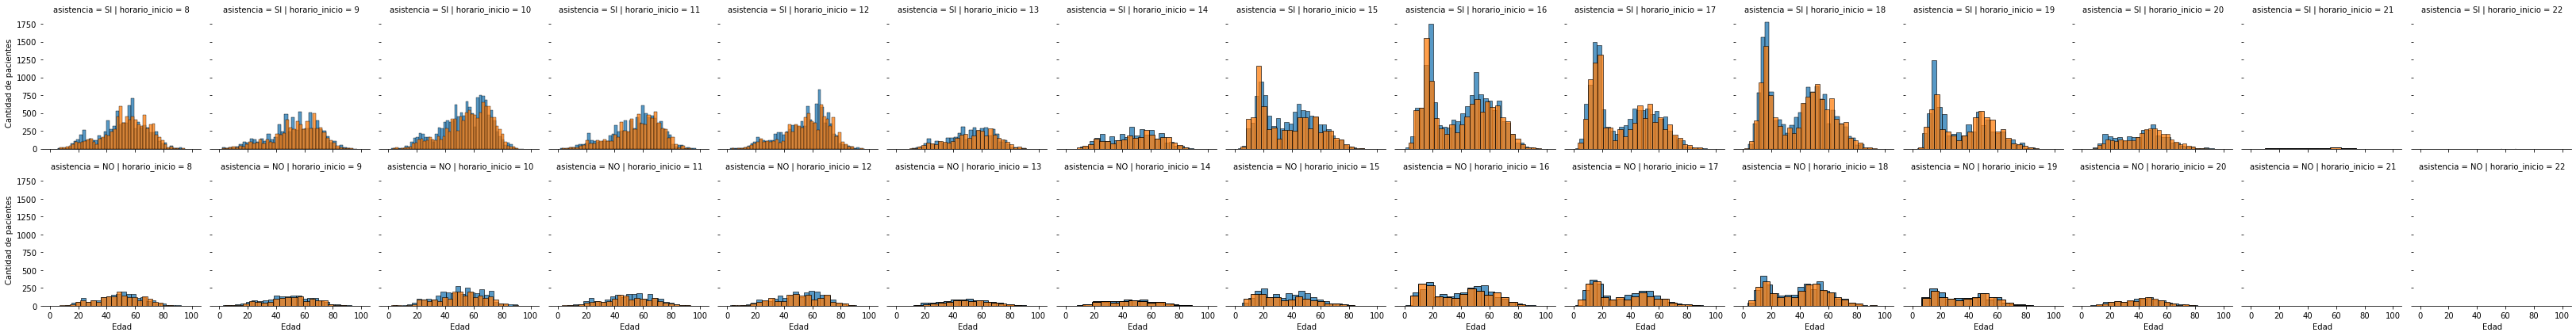

In [11]:
#distribucion de la edad por horario de la visita
g = sns.FacetGrid(df, col="horario_inicio",row="asistencia",hue="genero")
g.map(sns.histplot,  "edad2") .set_axis_labels("Edad", "Cantidad de pacientes")
_=g.despine(bottom=False, left=True)

# Creacion de modelos de prediccion

# otra opcion

In [10]:
rf = RandomForestClassifier()
rf_hyperparameters = {
    'n_estimators':[50,100,150],
    'max_depth':[2,4,8,None]
    }


lr = LogisticRegression()
lr_hyperparameters = {
    'C':[0.001,0.01,0.1,1,10,100,1000]
    }

dt = DecisionTreeClassifier()
dt_hyperparameters = {
    'max_depth':[2,3,4,8,None]
    }

NameError: name 'DecisionTreeClassifier' is not defined

## opcion 1 sin modificar mucho las columnas

In [3]:
def data_cleaning(df):
    dropLst = ["genero","nacionalidad2","edad","numero_total_visitas","fecha_cita","departamento","asistencia","año","numero de visita"
              ]
    le=LabelEncoder()
    inasistencia=[]#cambio a si (1) o no (0)
    for i in df.inasistencias_previas:
        if i==0:
            inasistencia.append(0)
        else:
            inasistencia.append(1)
    asis_previas=[]
    for i in df["numero de visita"]:#si ha venido antes o no
        if i==0:
            asis_previas.append(0)
        else:
            asis_previas.append(1)
    df["inasistencias_previas"]=inasistencia
    df["numero de visita"]=asis_previas
    #kbd=KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')#como hay muchos outliers en km, lo discretizo
    #df["km"]=kbd.fit_transform(df[["km"]]) pruebo sin modificarlo y unicamente quitando outliers
    df[["genero_masc","genero_fem"]]=pd.get_dummies(df.genero)
    df[["nac_esp","nac_no_esp"]]=pd.get_dummies(df.nacionalidad2)
    df=df[df.km<(df['km'].mean() + 3*df['km'].std())] #quito los outliers de km
    feature_names = df.drop(dropLst, axis=1).columns
    X = df.drop(dropLst, axis=1).values
    y = le.fit_transform(df['asistencia'])
    lb = LabelBinarizer()
    y = lb.fit_transform(y)
    return X, y, feature_names

In [4]:
#creo la X y la y
X=data_cleaning(df)[0]
y=data_cleaning(df)[1]
col_names=data_cleaning(df)[2]
df2=pd.DataFrame(X,columns=col_names)
df2["asistencia"]=y

C:\Users\irazu\anaconda3\lib\site-packages\seaborn\matrix.py:298: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


<AxesSubplot:title={'center':'Correlation'}>

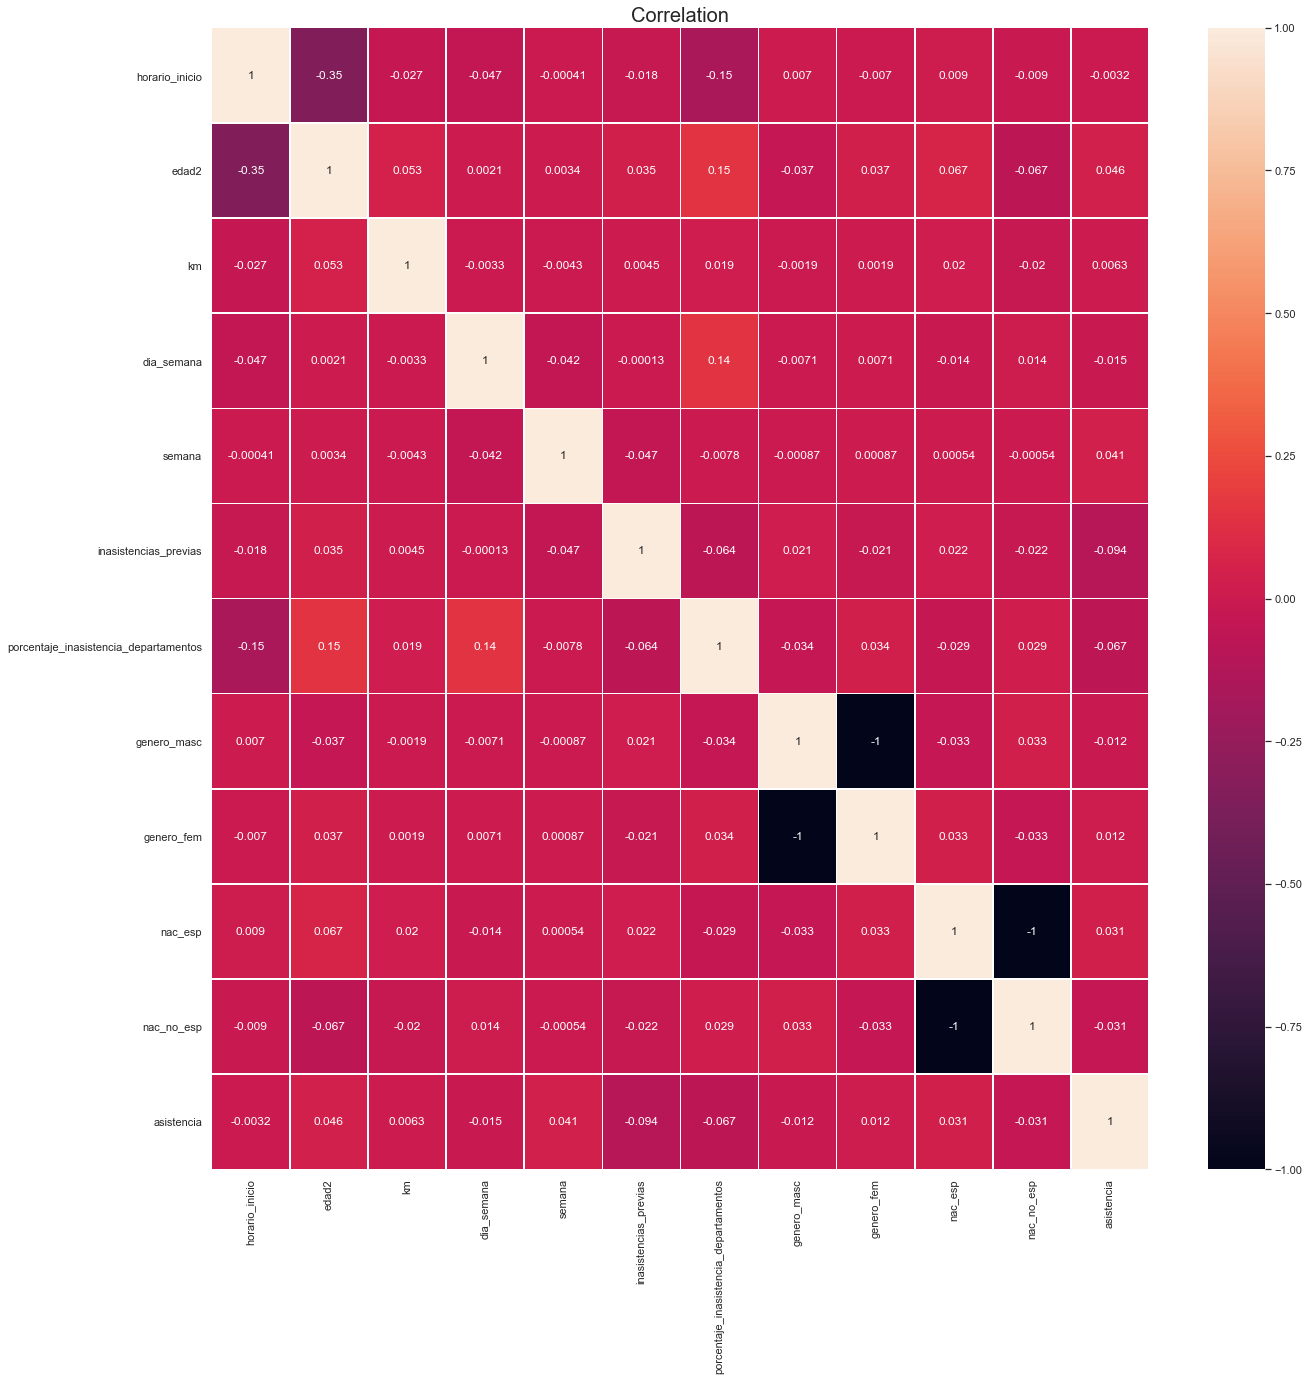

In [23]:
sns.set(font_scale=1)
plt.figure(figsize=(21,21))
plt.title("Correlation", fontsize=20)
sns.heatmap(df2.corr(),Linewidth=0.5, annot=True, linecolor='white')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=42)

In [6]:
# Balanceo del dataset, unicamente del conjunto de entrenamiento
res=SMOTE()
X_res,y_res=res.fit_resample(X_train,y_train)

In [28]:
### randomforestclassifier

In [26]:
rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_res, y_res)
CV_rfc.score(X_test,y_test)

0.8249486959813512

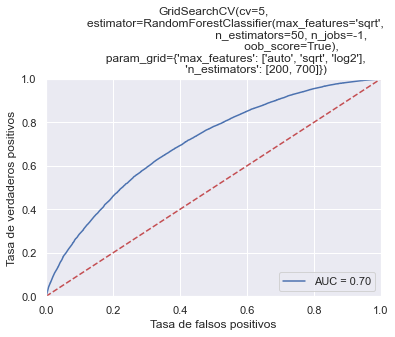

In [31]:
roc(CV_rfc,X_test,y_test)

In [33]:
print(classification_report(y_test,CV_rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.49      0.19      0.28      8723
           1       0.85      0.96      0.90     41468

    accuracy                           0.82     50191
   macro avg       0.67      0.57      0.59     50191
weighted avg       0.79      0.82      0.79     50191



### ExtraTreesClassifier

In [7]:
modelo_etc=ExtraTreesClassifier(n_estimators= 32)

In [8]:
modelo_etc.fit(X_res,y_res)

ExtraTreesClassifier(n_estimators=32)

In [36]:
modelo_etc.score(X_test,y_test)

0.813133828774083

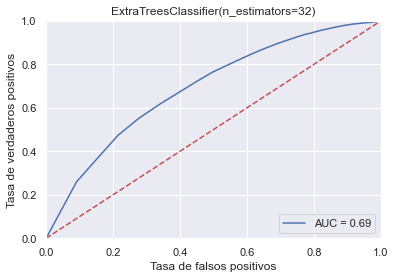

In [37]:
roc(modelo_etc,X_test,y_test)

In [38]:
print(classification_report(y_test,modelo_etc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.43      0.23      0.30      8723
           1       0.85      0.94      0.89     41468

    accuracy                           0.81     50191
   macro avg       0.64      0.58      0.60     50191
weighted avg       0.78      0.81      0.79     50191



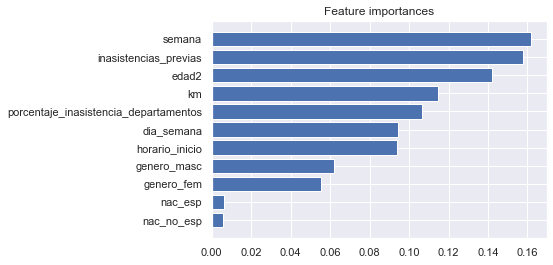

([array([0.09366067, 0.14209718, 0.11483366, 0.09458853, 0.16155315,
         0.15747852, 0.10650061, 0.06172968, 0.05537318, 0.00622666,
         0.00595817])],
 [Index(['nac_no_esp', 'nac_esp', 'genero_fem'], dtype='object')])

In [39]:
importancia_columnas(modelo_etc,col_names)

# Balanceo previo de los datos con SMOTE y split de la muestra

In [14]:
X=df[["horario_inicio","edad2","genero","nacionalidad2","km","dia_semana","semana","numero de visita",
      "inasistencias_previas","porcentaje_inasistencia_departamentos"]]
y=df.asistencia.replace("NO",0).replace("SI",1)

In [15]:
#lo convierto antes para que el smote funcione
X[["gen_masc","gen_fem"]]=pd.get_dummies(df.genero)
X[["nac_esp","nac_ext"]]=pd.get_dummies(df.nacionalidad2)
X.drop(["nacionalidad2","genero"],axis=1,inplace=True)

C:\Users\irazu\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\irazu\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [16]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X,y,test_size=.2, random_state=42)

In [17]:
res=SMOTE()
X_res_p,y_res_p=res.fit_resample(X_train_p,y_train_p)

## Scaling previo de X: y prueba con DecisionTree, RandoForest
Muy mala matrix de confusion y AUC

In [20]:
scaler= StandardScaler()
scaler.fit(X_train_p)
X_train_scaled= scaler.transform(X_train_p)
X_test_scaled=scaler.transform(X_test_p)

In [22]:
clf= DecisionTreeClassifier(criterion= 'entropy', random_state= 10)
clf.fit(X_train_scaled, y_train_p)

DecisionTreeClassifier(criterion='entropy', random_state=10)

In [31]:
ytree_test_preds= clf.predict(X_test_scaled)
ytree_train_preds= clf.predict(X_train_scaled)

probytree_test_preds= clf.predict_proba(X_test_scaled)
probytree_train_preds= clf.predict_proba(X_train_scaled)

In [32]:
print('Training Accuracy: ', accuracy_score(y_train_p, ytree_train_preds))
print('Testing Accuracy: ', accuracy_score(y_test_p, ytree_test_preds))
print('\n\n')

print('Training F1-Score: ', f1_score(y_train_p, ytree_train_preds))
print('Testing F1-Score: ', f1_score(y_test_p, ytree_test_preds))

Training Accuracy:  0.999737433986941
Testing Accuracy:  0.7579264426125555



Training F1-Score:  0.9998407715071127
Testing F1-Score:  0.8527554119859216


In [40]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_p, probytree_test_preds[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))


AUC is :0.59


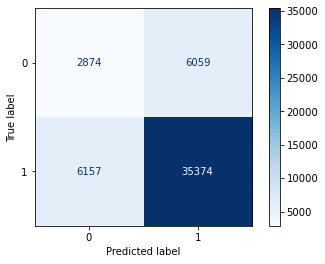

In [41]:
plot_confusion_matrix(clf, X_test_scaled, y_test_p,
                     cmap=plt.cm.Blues)
plt.show()

In [42]:
print(classification_report(y_test_p,clf.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.32      0.32      0.32      8933
           1       0.85      0.85      0.85     41531

    accuracy                           0.76     50464
   macro avg       0.59      0.59      0.59     50464
weighted avg       0.76      0.76      0.76     50464



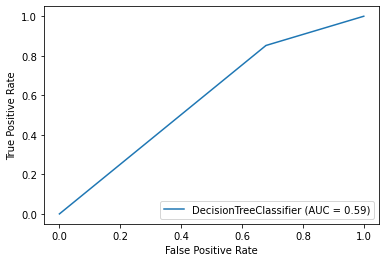

In [43]:
plot_roc_curve(clf, X_test_scaled, y_test_p)
plt.show()

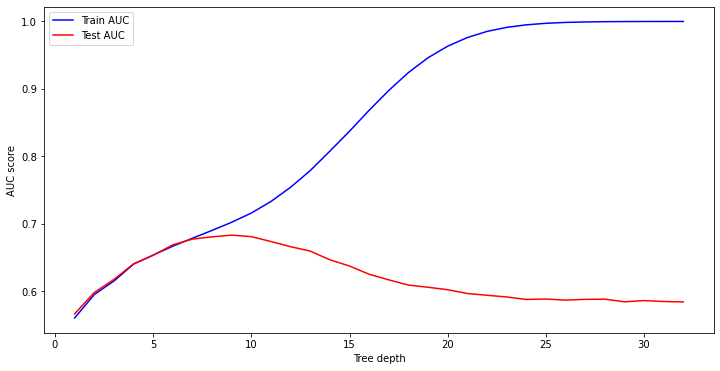

In [44]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=10)
   clf.fit(X_train_scaled, y_train_p)
   probytree_train_preds= clf.predict_proba(X_train_scaled)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_p, probytree_train_preds[:,1])
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   probytree_test_preds= clf.predict_proba(X_test_scaled)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_p, probytree_test_preds[:,1])
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()

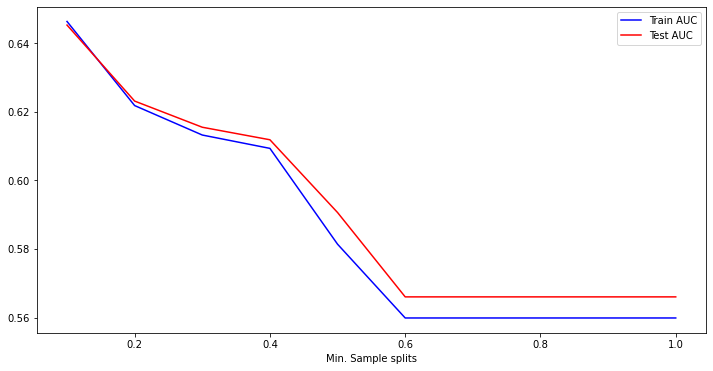

In [45]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   clf = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split, random_state=10)
   clf.fit(X_train_scaled, y_train_p)
   probytree_train_preds= clf.predict_proba(X_train_scaled)
   false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train_p, probytree_train_preds[:,1])
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   probytree_test_preds= clf.predict_proba(X_test_scaled)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_p, probytree_test_preds[:,1])
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.xlabel('Min. Sample splits')
plt.legend()
plt.show()

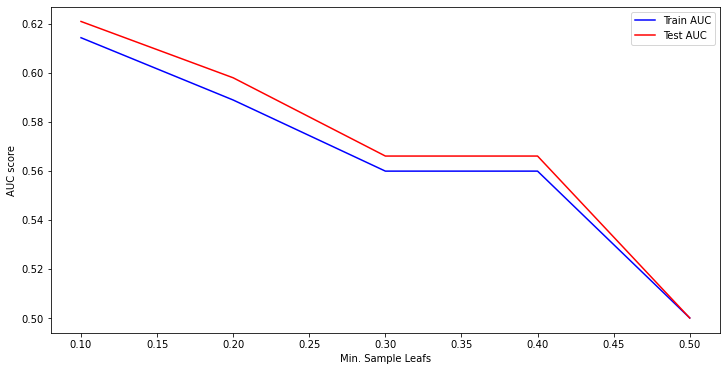

In [47]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   clf = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=min_samples_leaf, random_state=10)
   clf.fit(X_train_scaled, y_train_p)
   probytree_train_preds= clf.predict_proba(X_train_scaled)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_p, probytree_train_preds[:,1])
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   probytree_test_preds= clf.predict_proba(X_test_scaled)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_p, probytree_test_preds[:,1])
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
plt.figure(figsize=(12,6))    
plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Min. Sample Leafs')
plt.legend()
plt.show()

In [48]:
rf= RandomForestClassifier(criterion='entropy',
                           max_depth= 5,
                           min_samples_split= .5,
                           min_samples_leaf= .3, 
                           random_state=10,
                           class_weight= 'balanced')

In [49]:
rf.fit(X_train_scaled, y_train_p)
rf_test_preds= rf.predict_proba(X_test_scaled)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_p, rf_test_preds[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))


AUC is :0.56


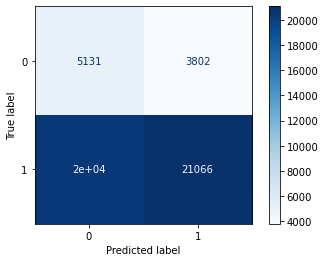

In [50]:
plot_confusion_matrix(rf, X_test_scaled, y_test_p,
                     cmap=plt.cm.Blues)
plt.show()

In [52]:
print(classification_report(y_test_p,rf.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.20      0.57      0.30      8933
           1       0.85      0.51      0.63     41531

    accuracy                           0.52     50464
   macro avg       0.52      0.54      0.47     50464
weighted avg       0.73      0.52      0.57     50464



In [54]:
params={
    'criterion': ['entropy'],
    'max_depth': [5,10,15,20],
    'min_samples_split': [.1,.3,.5,.7,.9],
    'min_samples_leaf': [.1,.2,.3,.4,.5]
    
}
gsearch=GridSearchCV(rf, params, scoring= 'f1')
gsearch.fit(X_train_scaled,y_train_p)

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              criterion='entropy', max_depth=5,
                                              min_samples_leaf=0.3,
                                              min_samples_split=0.5,
                                              random_state=10),
             param_grid={'criterion': ['entropy'], 'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'min_samples_split': [0.1, 0.3, 0.5, 0.7, 0.9]},
             scoring='f1')

In [55]:
gsearch.best_estimator_.score(X_test_scaled,y_test_p)

0.6485415345592898

In [56]:
gsearch.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1}

In [57]:
gsearchprob_test_preds=gsearch.best_estimator_.predict_proba(X_test_scaled)
gsearchprob_train_preds=gsearch.best_estimator_.predict_proba(X_train_scaled)

In [59]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_p, gsearchprob_test_preds[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))


AUC is :0.64


In [62]:
gsearch_test_preds=gsearch.best_estimator_.predict(X_test_scaled)
gsearch_train_preds=gsearch.best_estimator_.predict(X_train_scaled)

print('Training Recall: ', recall_score(y_train_p, gsearch_train_preds))
print('Testing Recall: ', recall_score(y_test_p, gsearch_test_preds))
print('\n\n')
print('Training F1-Score: ', f1_score(y_train_p, gsearch_train_preds))
print('Testing F1-Score: ', f1_score(y_test_p, gsearch_test_preds))

Training Recall:  0.675285664507912
Testing Recall:  0.6770845874166286



Training F1-Score:  0.7586074245047124
Testing F1-Score:  0.7602465664539853


In [63]:
print(classification_report(y_test_p,gsearch_test_preds))

              precision    recall  f1-score   support

           0       0.26      0.52      0.34      8933
           1       0.87      0.68      0.76     41531

    accuracy                           0.65     50464
   macro avg       0.56      0.60      0.55     50464
weighted avg       0.76      0.65      0.69     50464



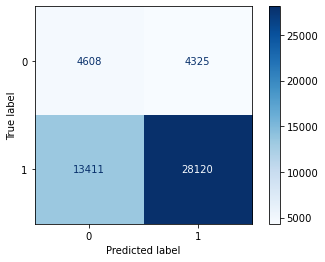

In [64]:
plot_confusion_matrix(gsearch.best_estimator_, X_test_scaled, y_test_p,
                     cmap=plt.cm.Blues)
plt.show()

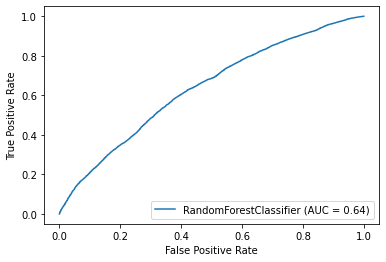

In [67]:
plot_roc_curve(gsearch.best_estimator_, X_test_scaled, y_test_p)
plt.show()

Text(0, 0.5, 'Feature Importance')

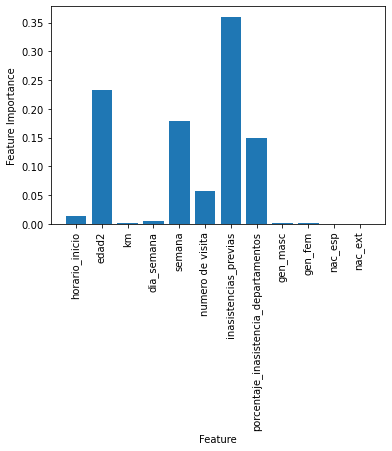

In [74]:
plt.bar(X.columns, gsearch.best_estimator_.feature_importances_)
plt.xticks(rotation= 90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')

### Categorizando columnas 

In [76]:
#discretizo variables numericas que son categoricas
categorical_cols=["horario_inicio","semana","dia_semana"]
numerical_cols=[ "edad2","km","numero de visita","inasistencias_previas","porcentaje_inasistencia_departamentos",
               "gen_masc","gen_fem","nac_esp","nac_ext"]
numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='mean'))
      ,('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='constant'))
      ,('encoder', OrdinalEncoder())
])
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numerical_cols),
      
   ('categorical', categorical_transformer, categorical_cols)
]) 

In [77]:
pipeline2 = Pipeline(steps = [
               ('preprocessor', preprocessor),
                ('selector', VarianceThreshold()),
              ('regressor',RandomForestRegressor())
           ])

In [78]:
pipeline2.fit(X_res_p, y_res_p)
 
print('Training set score: ' + str(pipeline2.score(X_res_p,y_res_p)))
print('Test set score: ' + str(pipeline2.score(X_test_p,y_test_p)))

Training set score: 0.9570111239945329
Test set score: 0.06727334864994616


In [92]:
pipeline3 = Pipeline(steps = [
               ('preprocessor', preprocessor),
                ('selector', VarianceThreshold()),
              ('classificador',RandomForestClassifier())
           ])

In [93]:
pipeline3.fit(X_res_p, y_res_p)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['edad2', 'km',
                                                   'numero de visita',
                                                   'inasistencias_previas',
                                                   'porcentaje_inasistencia_departamentos',
                                                   'gen_masc', 'gen_fem',
                                                   'nac_esp', 'nac_ext']),
                                                 ('categorical',
                                                  Pipeline(

In [94]:
print('Training set score: ' + str(pipeline3.score(X_res_p,y_res_p)))
print('Test set score: ' + str(pipeline3.score(X_test_p,y_test_p)))

Training set score: 0.9996335323873262
Test set score: 0.8218928344958782


In [95]:
print(classification_report(y_test_p,pipeline3.predict(X_test_p)))

              precision    recall  f1-score   support

           0       0.49      0.26      0.34      8933
           1       0.86      0.94      0.90     41531

    accuracy                           0.82     50464
   macro avg       0.68      0.60      0.62     50464
weighted avg       0.79      0.82      0.80     50464



In [97]:
#otro pipeline
pipeline4 = Pipeline(steps = [
               ('preprocessor', preprocessor),
                ('selector', VarianceThreshold()),
              ('classificador',LogisticRegression())
           ])
pipeline4.fit(X_res_p, y_res_p)
print('Training set score: ' + str(pipeline4.score(X_res_p,y_res_p)))
print('Test set score: ' + str(pipeline4.score(X_test_p,y_test_p)))

C:\Users\irazu\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training set score: 0.6740240546937892
Test set score: 0.7587983512999366


In [98]:
print(classification_report(y_test_p,pipeline4.predict(X_test_p)))

              precision    recall  f1-score   support

           0       0.28      0.23      0.25      8933
           1       0.84      0.87      0.86     41531

    accuracy                           0.76     50464
   macro avg       0.56      0.55      0.55     50464
weighted avg       0.74      0.76      0.75     50464



In [ ]:
regressor = RandomForestRegressor(random_state=42)
param_grid ={'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
            }
CV_rfc2 = RandomizedSearchCV(estimator=regressor, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
CV_rfc2.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 40.7min


### GaussianNB

In [45]:
df.head()

,fecha_cita,horario_inicio,edad,departamento,asistencia,edad2,km,genero,dia_semana,semana,año,numero de visita,numero_total_visitas,nacionalidad2,inasistencias_previas,porcentaje_inasistencia_departamentos,genero_masc,genero_fem,nac_esp,nac_no_esp
0,2018-09-03,9,1954-01-09,integrada,SI,68,53,femenino,1,36,2018,1,45,ESP,0,0.184216,1,0,1,0
1,2018-09-03,9,1988-02-15,integrada,SI,34,10,femenino,1,36,2018,1,9,ESP,0,0.184216,1,0,1,0
2,2018-09-03,9,1948-01-14,integrada,SI,74,9,femenino,1,36,2018,1,1,ESP,0,0.184216,1,0,1,0
3,2018-09-03,9,1998-04-20,integrada,SI,23,14,femenino,1,36,2018,1,39,ESP,0,0.184216,1,0,1,0
4,2018-09-03,11,1959-08-24,integrada,SI,62,3,femenino,1,36,2018,1,4,ESP,0,0.184216,1,0,1,0


In [107]:

pipeline_GNB= Pipeline(steps = [
               ('preprocessor', preprocessor),
                ('selector', VarianceThreshold())
              ,('classification',GaussianNB())
           ])
pipeline_GNB.fit(X_train_p, y_train_p)
    

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['edad2', 'km',
                                                   'numero de visita',
                                                   'inasistencias_previas',
                                                   'porcentaje_inasistencia_departamentos',
                                                   'gen_masc', 'gen_fem',
                                                   'nac_esp', 'nac_ext']),
                                                 ('categorical',
                                                  Pipeline(

In [111]:
pipeline_GNB.score(X_test_p,y_test_p)

0.8043555802155993

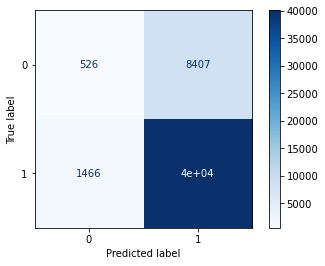

In [113]:
plot_confusion_matrix(pipeline_GNB, X_test_p, y_test_p,
                     cmap=plt.cm.Blues)
plt.show()

In [116]:
print(classification_report(y_test_p,pipeline_GNB.predict(X_test_p)))

              precision    recall  f1-score   support

           0       0.26      0.06      0.10      8933
           1       0.83      0.96      0.89     41531

    accuracy                           0.80     50464
   macro avg       0.55      0.51      0.49     50464
weighted avg       0.73      0.80      0.75     50464



# modelo con get_dumm

In [11]:
def data_cleaning(df):
    dropLst = ["genero","nacionalidad2","edad","numero_total_visitas","dia_semana","fecha_cita",
               "departamento","asistencia","horario_inicio","semana","año"]
   
    kbd=KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')#como hay muchos outliers en km, lo discretizo
    df["km"]=kbd.fit_transform(df[["km"]])
    df[["genero_masc","genero_fem"]]=pd.get_dummies(df.genero)
    df[pd.get_dummies(df.horario_inicio).columns]=pd.get_dummies(df.horario_inicio)
    df[pd.get_dummies(df.dia_semana).columns]=pd.get_dummies(df.dia_semana)
    df[pd.get_dummies(df.semana).columns]=pd.get_dummies(df.semana)
    df[["nac_esp","nac_no_esp"]]=pd.get_dummies(df.nacionalidad2)
  

    feature_names = df.drop(dropLst, axis=1).columns
    X = df.drop(dropLst, axis=1).values
    y = df['asistencia'].replace("SI",1).replace("NO",0)
    
    return X, y, feature_names

In [12]:
X=data_cleaning(df)[0]
y=data_cleaning(df)[1]
col_names=data_cleaning(df)[2]
df2=pd.DataFrame(X,columns=col_names)
df2["asistencia"]=y

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=42)

In [16]:
# Balanceo del dataset, sin modificar ni escalar columnas, unicamente cambiados los objects
res=SMOTE()
X_res,y_res=res.fit_resample(X_train,y_train)

In [17]:
modelo_etc=ExtraTreesClassifier(n_estimators= 32)

In [18]:
modelo_etc.fit(X_res,y_res)

ExtraTreesClassifier(n_estimators=32)

In [19]:
modelo_etc.score(X_test,y_test)

0.743064362714014

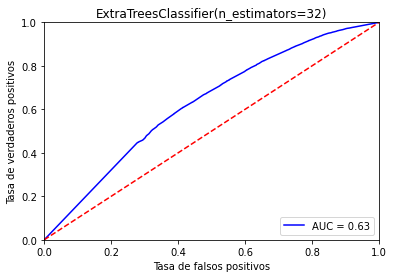

In [20]:
roc(modelo_etc,X_test,y_test)

In [ ]:
# ME quedo con el previo